#### 导入数据

In [1]:
# 导入数据
import numpy as np
import scipy.io as scio
offline_data = scio.loadmat('offline_data_random.mat')
online_data = scio.loadmat('online_data.mat')
offline_location, offline_rss = offline_data['offline_location'], offline_data['offline_rss']
trace, rss = online_data['trace'][0:1000, :], online_data['rss'][0:1000, :]
del offline_data
del online_data

In [2]:
# 定位精度
def accuracy(predictions, labels):
    return np.mean(np.sqrt(np.sum((predictions - labels)**2, 1)))

#### knn回归

In [11]:
# knn回归
from sklearn import neighbors
knn_reg = neighbors.KNeighborsRegressor(40, weights='uniform', metric='euclidean')
%time knn_reg.fit(offline_rss, offline_location)
%time predictions = knn_reg.predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, "m"

Wall time: 92 ms
Wall time: 182 ms
accuracy:  2.24421479398 m


#### knn分类

In [12]:
# knn分类，需要把坐标转换成网格标号，预测后将网格标号转换为坐标
labels = np.round(offline_location[:, 0]/100.0) * 100 + np.round(offline_location[:, 1]/100.0)
from sklearn import neighbors
knn_cls = neighbors.KNeighborsClassifier(n_neighbors=40, weights='uniform', metric='euclidean')
%time knn_cls.fit(offline_rss, labels)
%time predict_labels = knn_cls.predict(rss)
x = np.floor(predict_labels/100.0)
y = predict_labels - x * 100
predictions = np.column_stack((x, y)) * 100
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, 'm'

Wall time: 80 ms
Wall time: 251 ms
accuracy:  2.73213398632 m


#### 定位算法分析

加入数据预处理和交叉验证

In [5]:
# 预处理，标准化数据(其实RSS数据还算正常，不预处理应该也无所谓，特征选择什么的也都不需要)
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler().fit(offline_rss)
X_train = standard_scaler.transform(offline_rss)
Y_train = offline_location
X_test = standard_scaler.transform(rss)
Y_test = trace

In [44]:
# 交叉验证，在knn里用来选择最优的超参数k
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
parameters = {'n_neighbors':range(1, 50)}
knn_reg = neighbors.KNeighborsRegressor(weights='uniform', metric='euclidean')
clf = GridSearchCV(knn_reg, parameters)
clf.fit(offline_rss, offline_location)
scores = clf.cv_results_['mean_test_score']
k = np.argmax(scores) #选择score最大的k

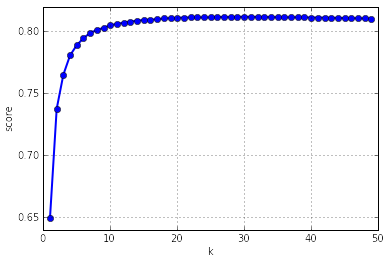

In [49]:
# 绘制超参数k与score的关系曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(1, scores.shape[0] + 1), scores, '-o', linewidth=2.0)
plt.xlabel("k")
plt.ylabel("score")
plt.grid(True)
plt.show()

In [47]:
# 使用最优的k做knn回归
knn_reg = neighbors.KNeighborsRegressor(n_neighbors=k, weights='uniform', metric='euclidean')
predictions = knn_reg.fit(offline_rss, offline_location).predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, "m"

accuracy:  2.22455511073 m


In [66]:
# 训练数据量与accuracy
k = 29
data_num = range(100, 30000, 300)
acc = []
for i in data_num:
    knn_reg = neighbors.KNeighborsRegressor(n_neighbors=k, weights='uniform', metric='euclidean')
    predictions = knn_reg.fit(offline_rss[:i, :], offline_location[:i, :]).predict(rss)
    acc.append(accuracy(predictions, trace) / 100)

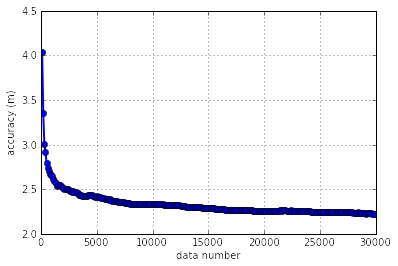

In [65]:
# 绘制训练数据量与accuracy的曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(data_num, acc, '-o', linewidth=2.0)
plt.xlabel("data number")
plt.ylabel("accuracy (m)")
plt.grid(True)
plt.show()


---

## 其他分类器

#### 导入数据

In [3]:
# 导入数据
import numpy as np
import scipy.io as scio
offline_data = scio.loadmat('offline_data_random.mat')
online_data = scio.loadmat('online_data.mat')
offline_location, offline_rss = offline_data['offline_location'], offline_data['offline_rss']
trace, rss = online_data['trace'][0:1000, :], online_data['rss'][0:1000, :]
del offline_data
del online_data

In [169]:
# 定位准确度定义
def accuracy(predictions, labels):
    return np.mean(np.sqrt(np.sum((predictions - labels + 0.0)**2, 1)))

#### Logistic regression （逻辑斯蒂回归）

In [29]:
# 逻辑斯蒂回归是用来分类的
labels = np.round(offline_location[:, 0]/100.0) * 100 + np.round(offline_location[:, 1]/100.0)
from sklearn.linear_model import LogisticRegressionCV
clf_l2_LR_cv = LogisticRegressionCV(Cs=20, penalty='l2', tol=0.001)
predict_labels = clf_l2_LR.fit(offline_rss, labels).predict(rss)
x = np.floor(predict_labels/100.0)
y = predict_labels - x * 100
predictions = np.column_stack((x, y)) * 100
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, 'm'

accuracy:  3.08581348591 m


#### Support Vector Machine for Regression （支持向量机）

In [10]:
from sklearn import svm
clf_x = svm.SVR(C=1000, gamma=0.01)
clf_y = svm.SVR(C=1000, gamma=0.01)
%time clf_x.fit(offline_rss, offline_location[:, 0])
%time clf_y.fit(offline_rss, offline_location[:, 1])
%time x = clf_x.predict(rss)
%time y = clf_y.predict(rss)
predictions = np.column_stack((x, y))
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, "m"

Wall time: 9min 27s
Wall time: 12min 42s
Wall time: 1.06 s
Wall time: 1.05 s
accuracy:  2.2468400825 m


#### Support Vector Machine for Classification （支持向量机）

In [18]:
from sklearn import svm
labels = np.round(offline_location[:, 0]/100.0) * 100 + np.round(offline_location[:, 1]/100.0)
clf_svc = svm.SVC(C=1000, tol=0.01, gamma=0.001)
%time clf_svc.fit(offline_rss, labels)
%time predict_labels = clf_svc.predict(rss)
x = np.floor(predict_labels/100.0)
y = predict_labels - x * 100
predictions = np.column_stack((x, y)) * 100
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, 'm'

Wall time: 1min 16s
Wall time: 15 s
accuracy:  2.50931890608 m


#### random forest regressor （随机森林）

In [30]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(n_estimators=150)
%time estimator.fit(offline_rss, offline_location)
%time predictions = estimator.predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, 'm'

Wall time: 58.6 s
Wall time: 196 ms
accuracy:  2.20778352008 m


#### random forest classifier （随机森林）

In [49]:
from sklearn.ensemble import RandomForestClassifier
labels = np.round(offline_location[:, 0]/100.0) * 100 + np.round(offline_location[:, 1]/100.0)
estimator = RandomForestClassifier(n_estimators=20, max_features=None, max_depth=20) # 内存受限，tree的数量有点少
%time estimator.fit(offline_rss, labels)
%time predict_labels = estimator.predict(rss)
x = np.floor(predict_labels/100.0)
y = predict_labels - x * 100
predictions = np.column_stack((x, y)) * 100
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, 'm'

Wall time: 39.6 s
Wall time: 113 ms
accuracy:  2.56860790666 m


#### Linear Regression （线性回归）

In [21]:
from sklearn.linear_model import LinearRegression
predictions = LinearRegression().fit(offline_rss, offline_location).predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, 'm'

accuracy:  3.83239841667 m


#### Ridge Regression （岭回归）

In [20]:
from sklearn.linear_model import RidgeCV
clf = RidgeCV(alphas=np.logspace(-4, 4, 10))
predictions = clf.fit(offline_rss, offline_location).predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, 'm'

accuracy:  3.83255676918 m


#### Lasso回归

In [18]:
from sklearn.linear_model import MultiTaskLassoCV
clf = MultiTaskLassoCV(alphas=np.logspace(-4, 4, 10))
predictions = clf.fit(offline_rss, offline_location).predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, 'm'

accuracy:  3.83244688001 m


#### Elastic Net （弹性网回归）

In [19]:
from sklearn.linear_model import MultiTaskElasticNetCV
clf = MultiTaskElasticNetCV(alphas=np.logspace(-4, 4, 10))
predictions = clf.fit(offline_rss, offline_location).predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, 'm'

accuracy:  3.832486036 m


#### Bayesian Ridge Regression （贝叶斯岭回归）

In [17]:
from sklearn.linear_model import BayesianRidge
from sklearn.multioutput import MultiOutputRegressor
clf = MultiOutputRegressor(BayesianRidge())
predictions = clf.fit(offline_rss, offline_location).predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, "m"

accuracy:  3.83243319129 m


#### Gradient Boosting for regression （梯度提升）

In [26]:
from sklearn import ensemble
from sklearn.multioutput import MultiOutputRegressor
clf = MultiOutputRegressor(ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=10))
%time clf.fit(offline_rss, offline_location)
%time predictions = clf.predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, "m"

Wall time: 43.4 s
Wall time: 17 ms
accuracy:  2.22100945095 m


#### Multi-layer Perceptron regressor （神经网络多层感知器）

In [22]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(hidden_layer_sizes=(100, 100))
%time clf.fit(offline_rss, offline_location)
%time predictions = clf.predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, "m"

Wall time: 1min 1s
Wall time: 6 ms
accuracy:  2.4517504109 m


---

## 目标跟踪

#### KNN + Kalman Filter

In [170]:
# knn回归
from sklearn import neighbors
knn_reg = neighbors.KNeighborsRegressor(40, weights='uniform', metric='euclidean')
knn_reg.fit(offline_rss, offline_location)
knn_predictions = knn_reg.predict(rss)
acc = accuracy(knn_predictions, trace)
print "accuracy: ", acc/100, "m"

accuracy:  2.24421479398 m


In [171]:
# 对knn定位结果进行卡尔曼滤波

from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
def kalman_tracker():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.
    # 状态转移矩阵
    tracker.F = np.array([[1, dt, 0,  0], 
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    # 用filterpy计算Q矩阵
    q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
    # tracker.Q = block_diag(q, q)
    tracker.Q = np.eye(4) * 0.01
    # tracker.B = 0
    # 观测矩阵
    tracker.H = np.array([[1., 0, 0, 0],
                          [0, 0, 1., 0]])
    # R矩阵
    tracker.R = np.array([[4., 0],
                          [0, 4.]])
    # 初始状态和初始P
    tracker.x = np.array([[7.4, 0, 3.3, 0]]).T 
    tracker.P = np.zeros([4, 4])
    return tracker

In [174]:
tracker = kalman_tracker()
zs = np.array([np.array([i]).T / 100. for i in knn_predictions]) # 除以100，单位为m
mu, cov, _, _ = tracker.batch_filter(zs) # 这个函数对一串观测值滤波
knn_kf_predictions = mu[:, [0, 2], :].reshape(1000, 2)
acc = accuracy(knn_kf_predictions, trace / 100.)
print "accuracy: ", acc, "m"

accuracy:  1.76116239607 m


#### KNN + Particle Filter

In [176]:
# knn回归
from sklearn import neighbors
knn_reg = neighbors.KNeighborsRegressor(40, weights='uniform', metric='euclidean')
knn_reg.fit(offline_rss, offline_location)
knn_predictions = knn_reg.predict(rss)
acc = accuracy(knn_predictions, trace)
print "accuracy: ", acc/100, "m"

accuracy:  2.24421479398 m


In [235]:
# 设计粒子滤波中各个步骤的具体实现

from numpy.random import uniform, randn, random, seed
from filterpy.monte_carlo import multinomial_resample
import scipy.stats
seed(7)

def create_particles(x_range, y_range, v_mean, v_std, N):
    """这里的粒子状态设置为（坐标x，坐标y，运动方向，运动速度）"""
    particles = np.empty((N, 4))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(0, 2 * np.pi, size=N)
    particles[:, 3] = v_mean + (randn(N) * v_std)
    return particles

def predict_particles(particles, std_heading, std_v, x_range, y_range):
    """这里的预测规则设置为：粒子根据各自的速度和方向（加噪声）进行运动，如果超出边界则随机改变方向再次尝试，"""
    idx = np.array([True] * len(particles))
    particles_last = np.copy(particles)
    for i in range(100): # 最多尝试100次
        if i == 0:
            particles[idx, 2] = particles_last[idx, 2] + (randn(np.sum(idx)) * std_heading)
        else:
            particles[idx, 2] = uniform(0, 2 * np.pi, size=np.sum(idx)) # 随机改变方向
        particles[idx, 3] = particles_last[idx, 3] + (randn(np.sum(idx)) * std_v)
        particles[idx, 0] = particles_last[idx, 0] + np.cos(particles[idx, 2] ) * particles[idx, 3]
        particles[idx, 1] = particles_last[idx, 1] + np.sin(particles[idx, 2] ) * particles[idx, 3]
        # 判断超出边界的粒子
        idx = ((particles[:, 0] < x_range[0])
                | (particles[:, 0] > x_range[1])
                | (particles[:, 1] < y_range[0]) 
                | (particles[:, 1] > y_range[1]))
        if np.sum(idx) == 0:
            break
            
def update_particles(particles, weights, z, d_std):
    """粒子更新，根据观测结果中得到的位置pdf信息来更新权重，这里简单地假设是真实位置到观测位置的距离为高斯分布"""
    # weights.fill(1.)
    distances = np.linalg.norm(particles[:, 0:2] - z, axis=1)
    weights *= scipy.stats.norm(0, d_std).pdf(distances)
    weights += 1.e-300
    weights /= sum(weights)

def estimate(particles, weights):
    """估计位置"""
    return np.average(particles, weights=weights, axis=0)

def neff(weights):
    """用来判断当前要不要进行重采样"""
    return 1. / np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
    """根据指定的样本进行重采样"""
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights /= np.sum(weights)
    
def run_pf(particles, weights, z, x_range, y_range):
    """迭代一次粒子滤波，返回状态估计"""
    x_range, y_range = [0, 20], [0, 15]
    predict_particles(particles, 0.5, 0.01, x_range, y_range) # 1. 预测
    update_particles(particles, weights, z, 4) # 2. 更新
    if neff(weights) < len(particles) / 2: # 3. 重采样
        indexes = multinomial_resample(weights)
        resample_from_index(particles, weights, indexes)
    return estimate(particles, weights) # 4. 状态估计

In [236]:
# 对knn定位结果进行粒子滤波

knn_pf_predictions = np.empty(knn_predictions.shape)
x_range, y_range = [0, 20], [0, 15]
n_particles = 50000
particles = create_particles(x_range, y_range, 0.6, 0.01, n_particles) # 初始化粒子
weights = np.ones(n_particles) / n_particles # 初始化权重

for i, pos in enumerate(knn_predictions):
    pos = pos.copy() / 100.
    state = run_pf(particles, weights, pos, x_range, y_range)
    knn_pf_predictions[i, :] = state[0:2]

acc = accuracy(knn_pf_predictions, trace / 100.)
print "final state: ", state
print "accuracy: ", acc, "m"

final state:  [  8.16137026  12.49569879   4.06952385   0.54954716]
accuracy:  1.80881825483 m


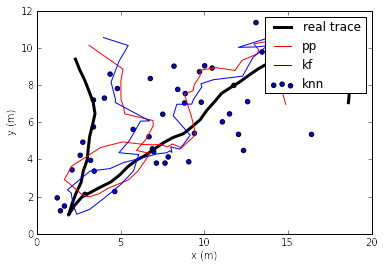

In [268]:
import matplotlib.pyplot as plt
%matplotlib inline
x_i = range(500, 550)
tr, = plt.plot(trace[x_i, 0] / 100., trace[x_i, 1] / 100., 'k-', linewidth=3)
pf, = plt.plot(knn_pf_predictions[x_i, 0], knn_pf_predictions[x_i, 1], 'r-')
kf, = plt.plot(knn_kf_predictions[x_i, 0], knn_kf_predictions[x_i, 1], 'b-')
knn_ = plt.scatter(knn_predictions[x_i, 0] / 100., knn_predictions[x_i, 1] / 100.)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend([tr, pf, kf, knn_], ["real trace", "pp", "kf", "knn"])
plt.show()